# Functions Development

In [102]:
# Import Libraries and Setup
import pandas as pd
import yfinance as yf
import matplotlib.pyplot as plt
from datetime import datetime, timedelta

# Set up display options for pandas
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)

print("Libraries imported successfully!")

## Function 1: Get Stock Data and Explore
def get_stocks_data(symbols, start_date, end_date):
    """
    Get data for multiple stocks, however it rest of the code relies on a single stock's data structure.
    More testing & development to come for multi-stock support.
    """
    if isinstance(symbols, str):
        symbols = [symbols]  # Convert single string to list
    
    print(f"Getting data for {symbols} from {start_date} to {end_date}...")
    data = yf.download(symbols, start=start_date, end=end_date)
    print(f"Got {len(data)} days of data for {len(symbols)} stocks")
    
    # Flatten if only one stock to keep it simple
    if len(symbols) == 1:
        data = data.droplevel(1, axis=1)
    
    return data
    
## Function 2: Define and Test Dip Buying Strategy
def dip_buying_strategy(data, daily_budget=10, dip_threshold=0.10):
    """
    Buy when stock drops by dip_threshold (default 10%) from recent peak
    Money accumulates daily until a dip occurs
    """
    cash = 0
    shares = 0
    transactions = []
    daily_values = pd.Series(dtype=float)

    # Track the highest price seen so far (rolling peak)
    peak_price = data['Close'].iloc[0]
    
    print(f"Running Dip Buying Strategy:")
    print(f"- Daily budget: ${daily_budget}")
    print(f"- Dip threshold: {dip_threshold*100}%")
    print(f"- Starting peak price: ${peak_price:.2f}")
    print()
    
    for i, (date, row) in enumerate(data.iterrows()):
        current_price = row['Close']
        cash += daily_budget  # Add daily budget
        
        # Update peak price if current price is higher
        if current_price > peak_price:
            peak_price = current_price
        
        # Check if current price is below the dip threshold
        dip_price = peak_price * (1 - dip_threshold)
        
        if current_price <= dip_price and cash >= current_price:
            # Buy as many shares as possible with accumulated cash
            shares_to_buy = int(cash / current_price)
            # Remove this redundant check: if shares_to_buy > 0:
            
            cost = shares_to_buy * current_price
            cash -= cost
            shares += shares_to_buy
            
            dip_percent = ((peak_price - current_price) / peak_price) * 100
            
            transactions.append({
                'Date': date,
                'Price': current_price,
                'Shares': shares_to_buy,
                'Cost': cost,
                'Peak': peak_price,
                'Dip_Percent': dip_percent
            })
            
            # print(f"{date.strftime('%Y-%m-%d')}: Bought {shares_to_buy} shares at ${current_price:.2f}")
            # print(f"   -> {dip_percent:.1f}% dip from peak of ${peak_price:.2f}")
            # print(f"   -> Spent ${cost:.2f}, Cash remaining: ${cash:.2f}")
            # print()
            peak_price = current_price

        # Calculate total portfolio value
        portfolio_value = cash + (shares * current_price)
        daily_values.at[date] = portfolio_value

    total_invested = len(data) * daily_budget
    final_value = cash + (shares * data['Close'].iloc[-1])
    
    return {
        'daily_values': daily_values,
        'transactions': transactions,
        'final_value': final_value,
        'total_invested': total_invested,
        'cash_remaining': cash,
        'shares': shares
    }

## Plotting Function
def plot_stock_data(data, ticker):
    """
    Plot the closing price of the stock data.
    """
    plt.figure(figsize=(12, 6))
    plt.plot(data.index, data['Close'], linewidth=2)
    plt.title(f'{ticker} Stock Price Over Last Year')
    plt.xlabel('Date')
    plt.ylabel('Price ($)')
    plt.grid(True, alpha=0.3)
    plt.show()

## Function 3: Dollar Cost averaging Strategy (weekly)
def dollar_cost_averaging_strategy(data, daily_budget=10, buy_frequency=7):
    """
    Buy every week (every 7 days) with accumulated money
    """
    cash = 0
    shares = 0
    transactions = []
    daily_values = pd.Series(dtype=float)

    print(f"Running Weekly Dollar cost averaging Strategy:")
    print(f"- Daily budget: ${daily_budget}")
    print(f"- Buying frequency: every {buy_frequency} days")
    print()

    for i, (date, row) in enumerate(data.iterrows()):
        current_price = row['Close']
        cash += daily_budget
        if i % buy_frequency == 0 and cash >= current_price:
            shares_to_buy = int(cash / current_price)
            cost = shares_to_buy * current_price
            cash -= cost
            shares += shares_to_buy
            transactions.append({
                'Date': date,
                'Price': current_price,
                'Shares': shares_to_buy,
                'Cost': cost
                })
                
            # print(f"{date.strftime('%Y-%m-%d')}: Bought {shares_to_buy} shares at ${current_price:.2f}")
            # print(f"   -> Spent ${cost:.2f}, Cash remaining: ${cash:.2f}")
            # print()
        daily_values.at[date] = cash + (shares * current_price)
    total_invested = len(data) * daily_budget
    final_value = cash + (shares * data['Close'].iloc[-1])
    return {
        'daily_values': daily_values,
        'transactions': transactions,
        'final_value': final_value,
        'total_invested': total_invested,
        'cash_remaining': cash,
        'shares': shares
    }



Libraries imported successfully!


_______________________________________________________________________________________________________________________________________________________________________________________

# Testing Area

In [103]:
# # Get AAPL data - Testing Code
# data = yf.download("AAPL", start="2020-08-27", end="2020-09-03", actions=True)
# print("Columns:", data.columns.tolist())

# # Check if we have a split during this period
# ticker = yf.Ticker("AAPL")
# splits = ticker.splits

# # Remove timezone from splits index for comparison
# splits_index_naive = splits.index.tz_convert(None)

# # Compare with naive indices
# mask = (splits_index_naive >= data.index[0]) & (splits_index_naive <= data.index[-1])
# print("Splits in date range:", splits[mask])
# print(data.head())

In [104]:
#variable initialization
end_date = datetime.now()
years = 5
start_date = end_date - timedelta(days=365*years)
symbol = 'VFV.TO'
daily_budget = 72  # $72 per day
dip_threshold = 0.1
data = get_stocks_data(symbol, start_date.strftime('%Y-%m-%d'), end_date.strftime('%Y-%m-%d'))


C:\Users\lippm\AppData\Local\Temp\ipykernel_20452\2480664711.py:23: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(symbols, start=start_date, end=end_date)
[*********************100%***********************]  1 of 1 completed

Getting data for ['VFV.TO'] from 2020-08-27 to 2025-08-26...
Got 1253 days of data for 1 stocks


In [105]:

# Explore the data
print("\nFirst 5 rows of data:")
print(data.head())

print(f"\nStock price range:")
print(f"Lowest: ${data['Close'].min():.2f}")
print(f"Highest: ${data['Close'].max():.2f}")
print(f"Average: ${data['Close'].mean():.2f}")


First 5 rows of data:
Price           Close       High        Low       Open  Volume
Date                                                          
2020-08-27  76.592560  77.223376  76.281857  77.223376   45700
2020-08-28  76.922066  76.922066  76.385400  76.856160   48400
2020-08-31  76.451332  76.969170  76.357182  76.969170   63900
2020-09-01  77.204536  77.204536  76.347751  76.451319   48100
2020-09-02  78.249626  78.372021  77.486998  77.647055   73000

Stock price range:
Lowest: $72.58
Highest: $158.75
Average: $107.04


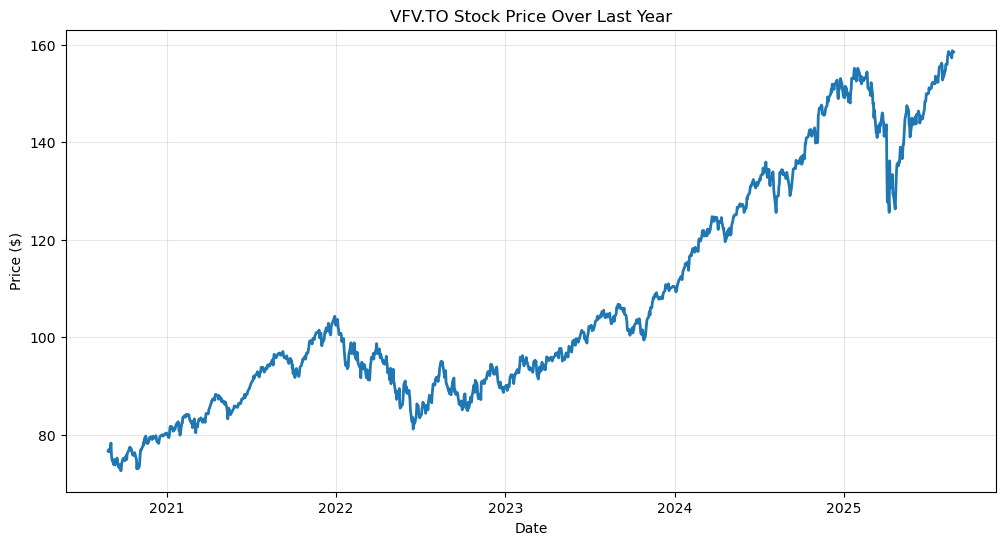

We'll be testing strategies on this 1253-day period


In [106]:
## Plotting Function 1: Plot Stock Price to See What We're Working With
plot_stock_data(data, symbol)

print(f"We'll be testing strategies on this {len(data)}-day period")


In [107]:
# Test the dip buying strategy

dip_results = dip_buying_strategy(data, daily_budget=daily_budget, dip_threshold=dip_threshold)

print("="*50)
print("DIP BUYING STRATEGY RESULTS:")
print("="*50)
print(f"Total money allocated: ${dip_results['total_invested']:,.2f}")
print(f"Final portfolio value: ${dip_results['final_value']:,.2f}")
print(f"Cash remaining: ${dip_results['cash_remaining']:.2f}")
print(f"Shares owned: {dip_results['shares']}")
print(f"Number of purchases: {len(dip_results['transactions'])}")

dip_profit = dip_results['final_value'] - dip_results['total_invested']
dip_profit_percent = (dip_profit / dip_results['total_invested']) * 100
print(f"Profit: ${dip_profit:,.2f} ({dip_profit_percent:.1f}%)")
print("_"*50)
print()

# Testing Dollar Cost Averaging
dollar_cost_averaging_results = dollar_cost_averaging_strategy(data, daily_budget=daily_budget, buy_frequency=7)
print("="*50)
print("Dollar Cost Averaging Results:")
print("="*50)

print(f"Total money allocated: ${dollar_cost_averaging_results['total_invested']:,.2f}")
print(f"Final portfolio value: ${dollar_cost_averaging_results['final_value']:,.2f}")
print(f"Cash remaining: ${dollar_cost_averaging_results['cash_remaining']:.2f}")
print(f"Shares owned: {dollar_cost_averaging_results['shares']}")
print(f"Number of purchases: {len(dollar_cost_averaging_results['transactions'])}")

dollar_cost_avg_profit = dollar_cost_averaging_results['final_value'] - dollar_cost_averaging_results['total_invested']
dollar_cost_avg_profit_percent = (dollar_cost_avg_profit / dollar_cost_averaging_results['total_invested']) * 100
print(f"Profit: ${dollar_cost_avg_profit:,.2f} ({dollar_cost_avg_profit_percent:.1f}%)")


Running Dip Buying Strategy:
- Daily budget: $72
- Dip threshold: 10.0%
- Starting peak price: $76.59

DIP BUYING STRATEGY RESULTS:
Total money allocated: $90,216.00
Final portfolio value: $126,515.23
Cash remaining: $7164.73
Shares owned: 753
Number of purchases: 5
Profit: $36,299.23 (40.2%)
__________________________________________________

Running Weekly Dollar cost averaging Strategy:
- Daily budget: $72
- Buying frequency: every 7 days

Dollar Cost Averaging Results:
Total money allocated: $90,216.00
Final portfolio value: $139,294.80
Cash remaining: $448.80
Shares owned: 876
Number of purchases: 178
Profit: $49,078.80 (54.4%)


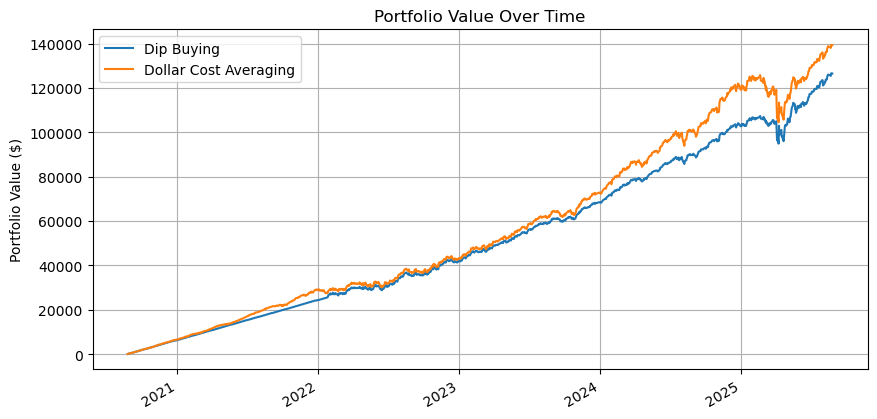

In [108]:
# plotting daily values:
dip_results['daily_values'].plot(figsize=(10, 5), label="Dip Buying", title="Portfolio Value Over Time", ylabel="Portfolio Value ($)")
dollar_cost_averaging_results['daily_values'].plot(label="Dollar Cost Averaging")
plt.grid(True)
plt.legend()
plt.show()


In [109]:
# Comprare the two Strategies
print("="*70)
print("STRATEGY COMPARISON")
print("="*70)
# Keys serve as column headers, [] = rows values. 
comparison_data = {
    'Metric': ['Final Value', 'Return(%)', 'Purchases', 'Cash Remaining', 'Shares Owned'],
    f'Dip Buying ({dip_threshold*100:.1f}%)': [
        f'{dip_results['final_value']:,.2f}',
        f'{dip_profit_percent:.1f}%',
        len(dip_results['transactions']),
        f'{dip_results['cash_remaining']:,.2f}',
        dip_results['shares']
    ],
    'Dollar Cost Averaging': [
        f'{dollar_cost_averaging_results['final_value']:,.2f}',
        f'{dollar_cost_avg_profit_percent:.1f}%',
        len(dollar_cost_averaging_results['transactions']),
        f'{dollar_cost_averaging_results['cash_remaining']:,.2f}',
        dollar_cost_averaging_results['shares']
    ]
}
comparison_df = pd.DataFrame(comparison_data)
print(comparison_df)

STRATEGY COMPARISON
           Metric Dip Buying (10.0%) Dollar Cost Averaging
0     Final Value         126,515.23            139,294.80
1       Return(%)              40.2%                 54.4%
2       Purchases                  5                   178
3  Cash Remaining           7,164.73                448.80
4    Shares Owned                753                   876
